# Introduction
<a id="Introduction"></a>

In [2]:
import time
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

from scipy.stats import kruskal
from scipy.stats import anderson
from datetime import datetime


from functions import load_api_key, plotting

pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

# Primary Data
<a id="Primary-Data"></a>

In [3]:
rental_data_df = pd.read_csv('inputs/RentingOutofFlats2024CSV.csv')

In [13]:
rental_data_df.shape

(142826, 11)

In [14]:
rental_data_df.head()

,rent_approval_date,town,block,street_name,flat_type,monthly_rent,date,year,month,year_month,address
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000,2021-01-01,2021,1,2021_1,105 ANG MO KIO AVE 4
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750,2021-01-01,2021,1,2021_1,107 ANG MO KIO AVE 4
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750,2021-01-01,2021,1,2021_1,108 ANG MO KIO AVE 4
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230,2021-01-01,2021,1,2021_1,111 ANG MO KIO AVE 4
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450,2021-01-01,2021,1,2021_1,111 ANG MO KIO AVE 4


In [15]:
rental_data_df.isna().sum().sum() == 0

True

In [16]:
rental_data_df['date']       = pd.to_datetime(rental_data_df['rent_approval_date'], errors = 'coerce')
rental_data_df['year']       = rental_data_df['date'].dt.year.astype('str')
rental_data_df['month']      = rental_data_df['date'].dt.month.astype('str')
rental_data_df['year_month'] = rental_data_df['year'] + '_' + rental_data_df['month']
rental_data_df['address'] = rental_data_df['block'] + ' ' + rental_data_df['street_name'] 

In [28]:
rental_data_df['year_month'].min(), rental_data_df['year_month'].max()

('2021_1', '2024_9')

In [18]:
rental_data_df.groupby('year').size()

year
2021    38882
2022    33612
2023    36854
2024    33478
dtype: int64

In [45]:
df = rental_data_df.groupby(['year', 'town']).size().reset_index()
df.to_csv('temp.csv')

In [19]:
rental_data_df['town'].nunique()

27

In [20]:
rental_data_df.groupby('town').size().sort_values().head()

town
TENGAH              2
BUKIT TIMAH       429
MARINE PARADE    1558
CENTRAL          2165
BISHAN           3166
dtype: int64

In [40]:
df = rental_data_df.groupby(['year','town'])['monthly_rent'].mean().reset_index()
df.loc[df.groupby('year')['monthly_rent'].idxmax()]

,year,town,monthly_rent
7,2021,CENTRAL,2404.308664
33,2022,CENTRAL,2922.990119
59,2023,CENTRAL,3525.091696
85,2024,CENTRAL,3606.237192


In [21]:
rental_data_df.groupby('town').size().sort_values(ascending = False).head()

town
JURONG WEST    9947
TAMPINES       9510
SENGKANG       9282
BEDOK          8497
ANG MO KIO     7868
dtype: int64

In [22]:
rental_data_df.groupby('flat_type').size()

flat_type
1-ROOM          44
2-ROOM        2889
3-ROOM       46576
4-ROOM       51455
5-ROOM       33919
EXECUTIVE     7943
dtype: int64

# Exploratory Data Analysis
<a id="EDA"></a>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


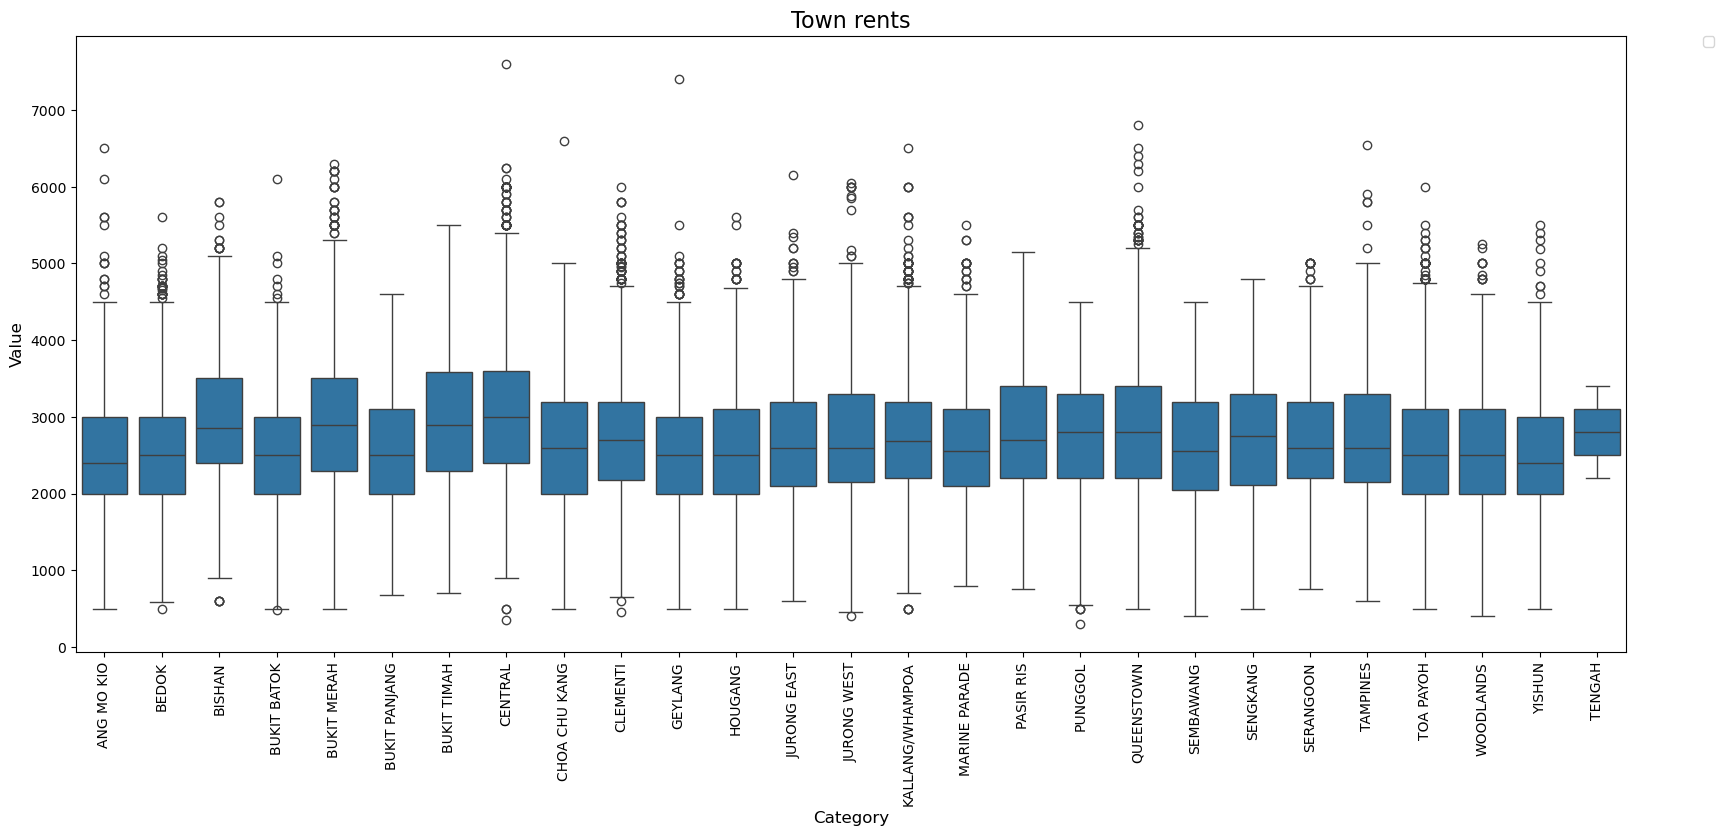

In [23]:
plotting('Town rents', 'boxplot', rental_data_df, 'town', 'monthly_rent')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


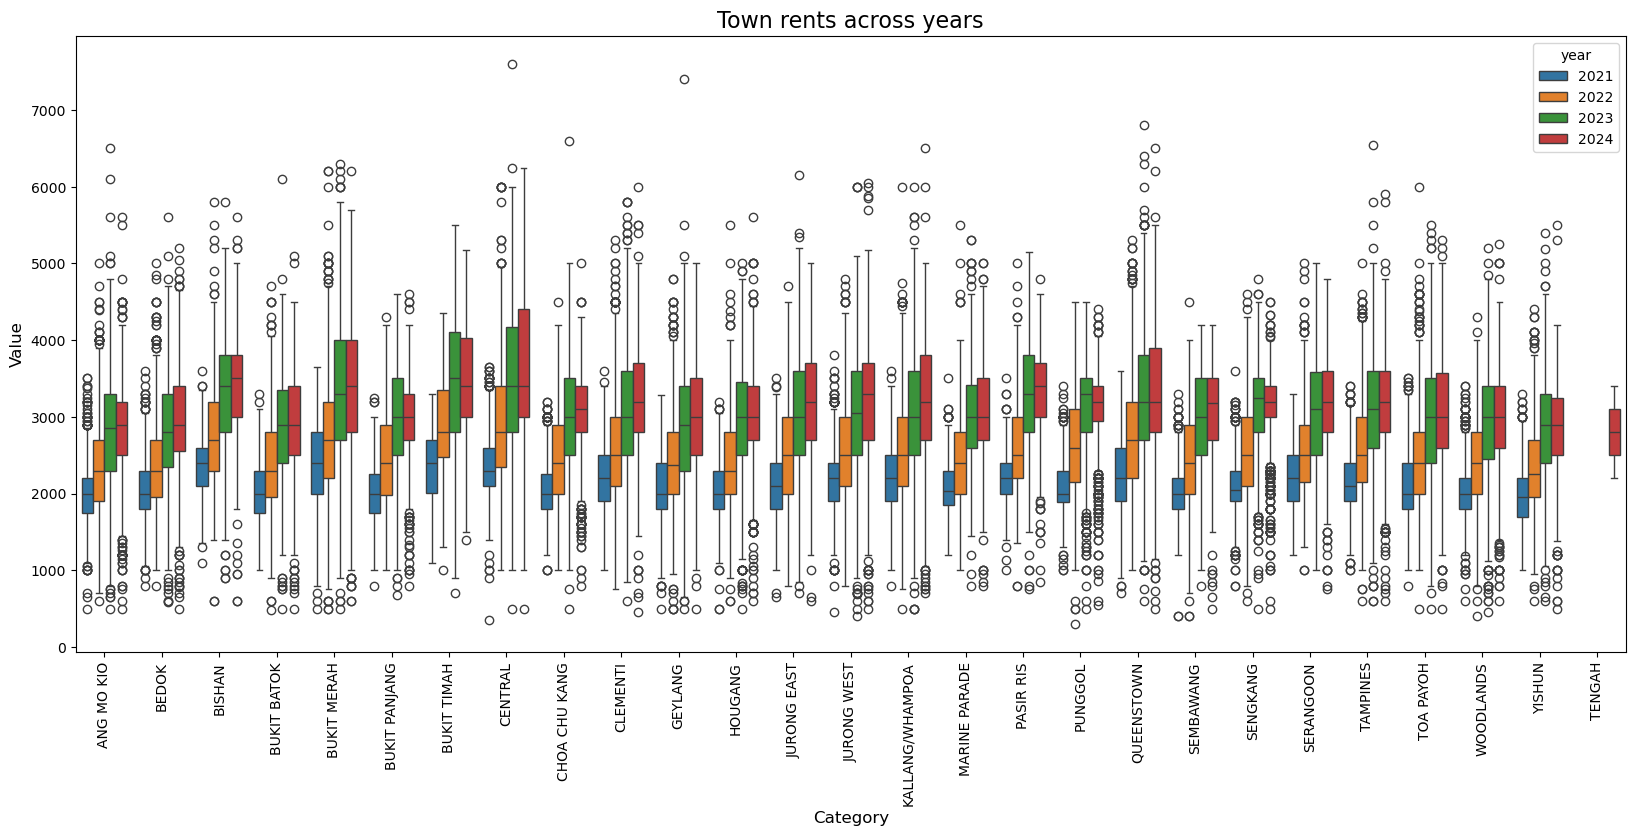

In [24]:
plotting('Town rents across years', 'boxplot', rental_data_df, 'town', 'monthly_rent', 'year')

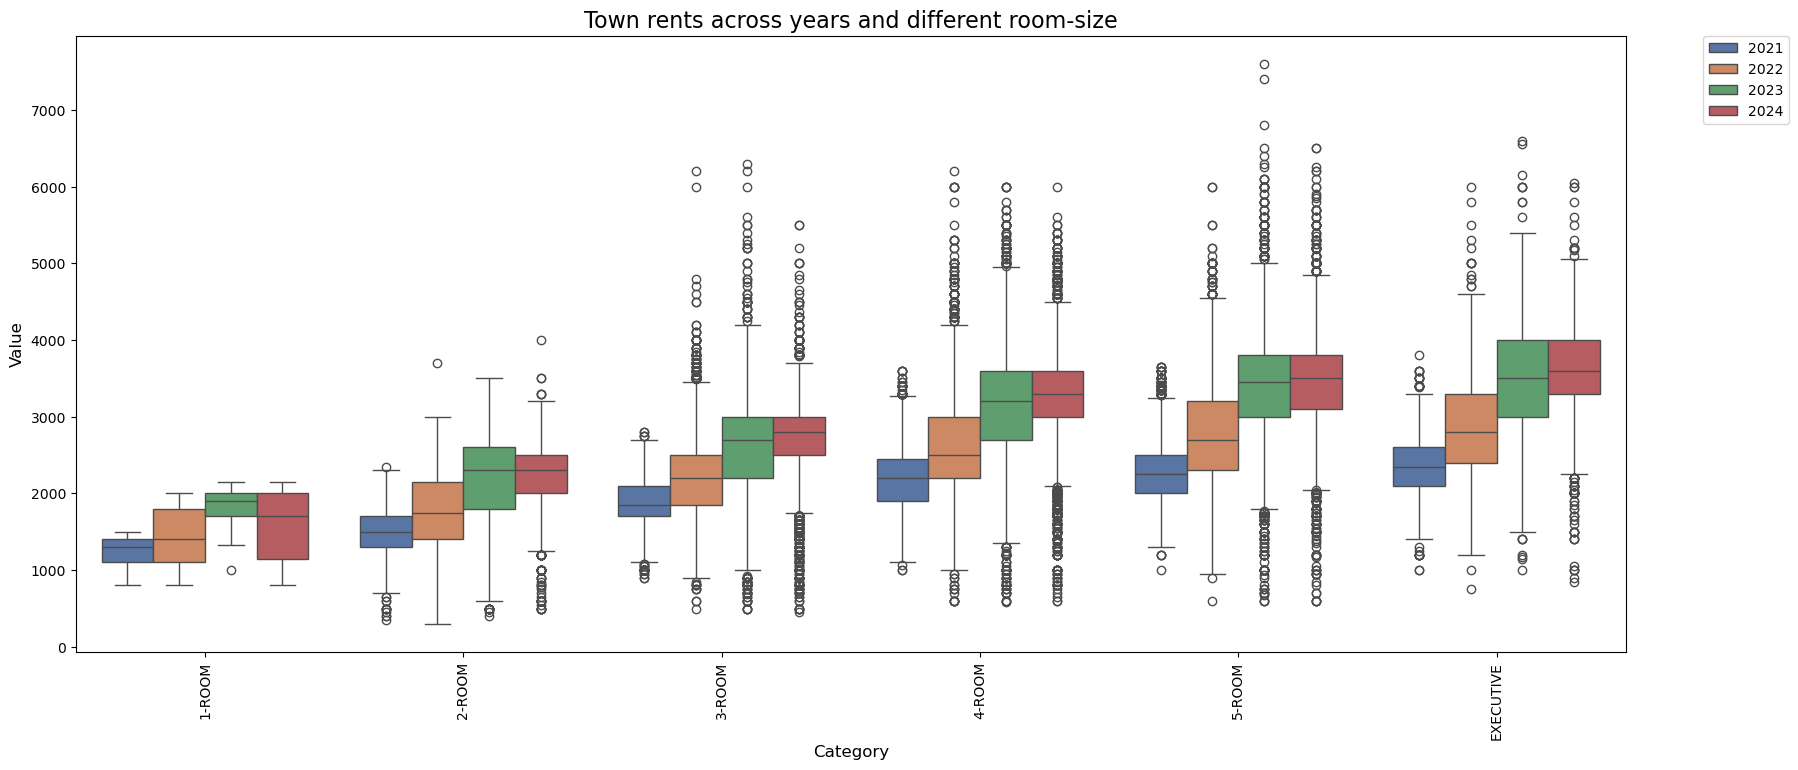

In [27]:
plotting('Town rents across years and different room-size', 'boxplot', rental_data_df, 'flat_type', 'monthly_rent', 'year', desired_order = rental_data_df['flat_type'].sort_values().unique().tolist())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


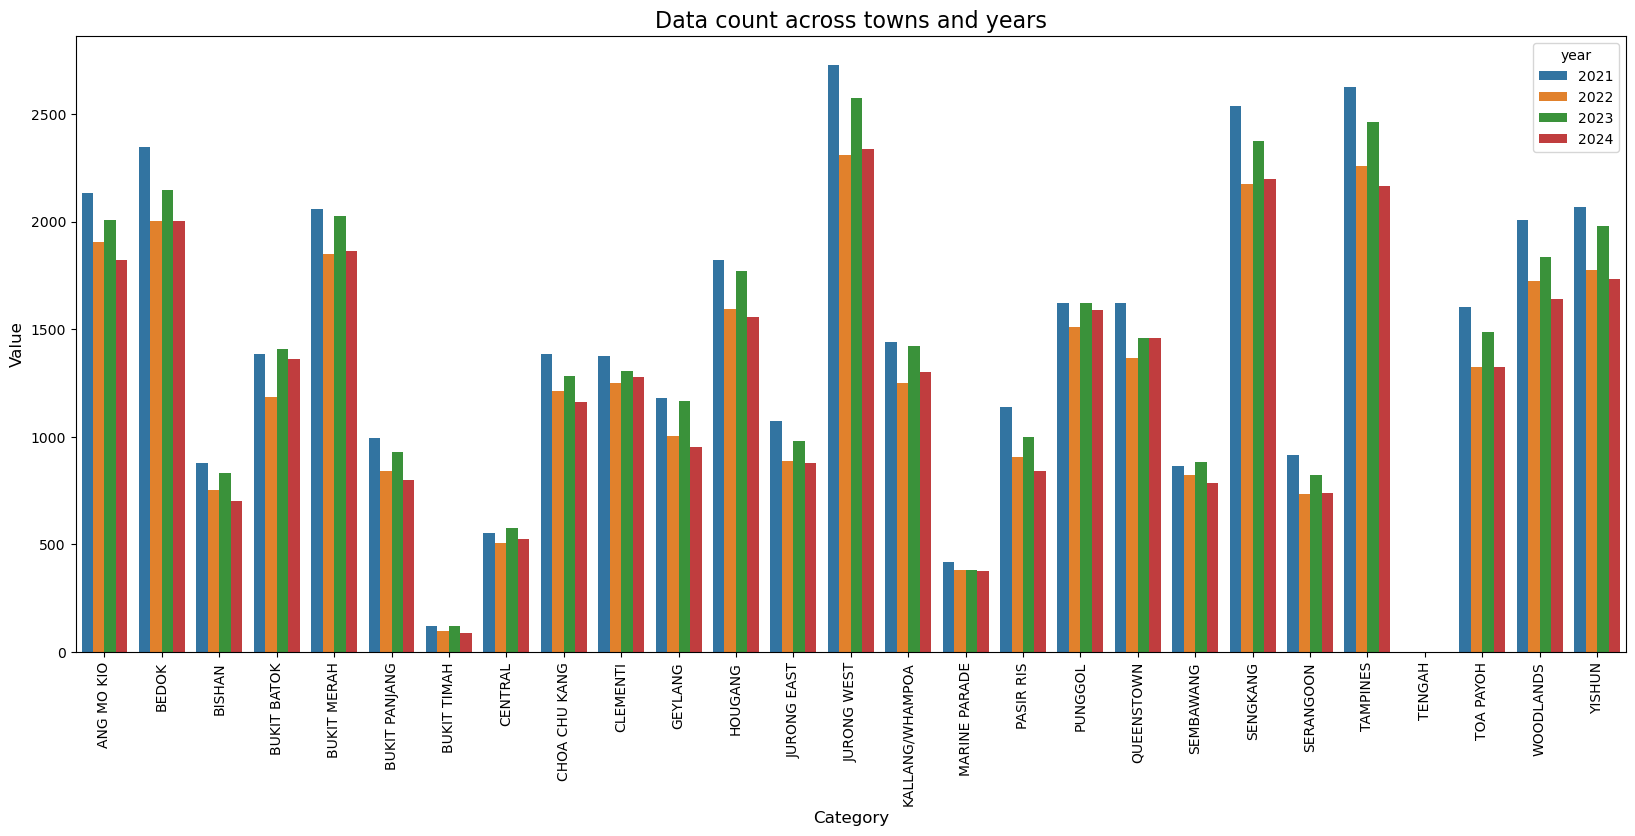

In [26]:
df = rental_data_df.groupby(['town', 'year']).size().reset_index()
df = df.rename(columns = {0:'count'})
plotting('Data count across towns and years', 'barplot', df, 'town', 'count', 'year')

# Statistical Testing
<a id="Stats"></a>

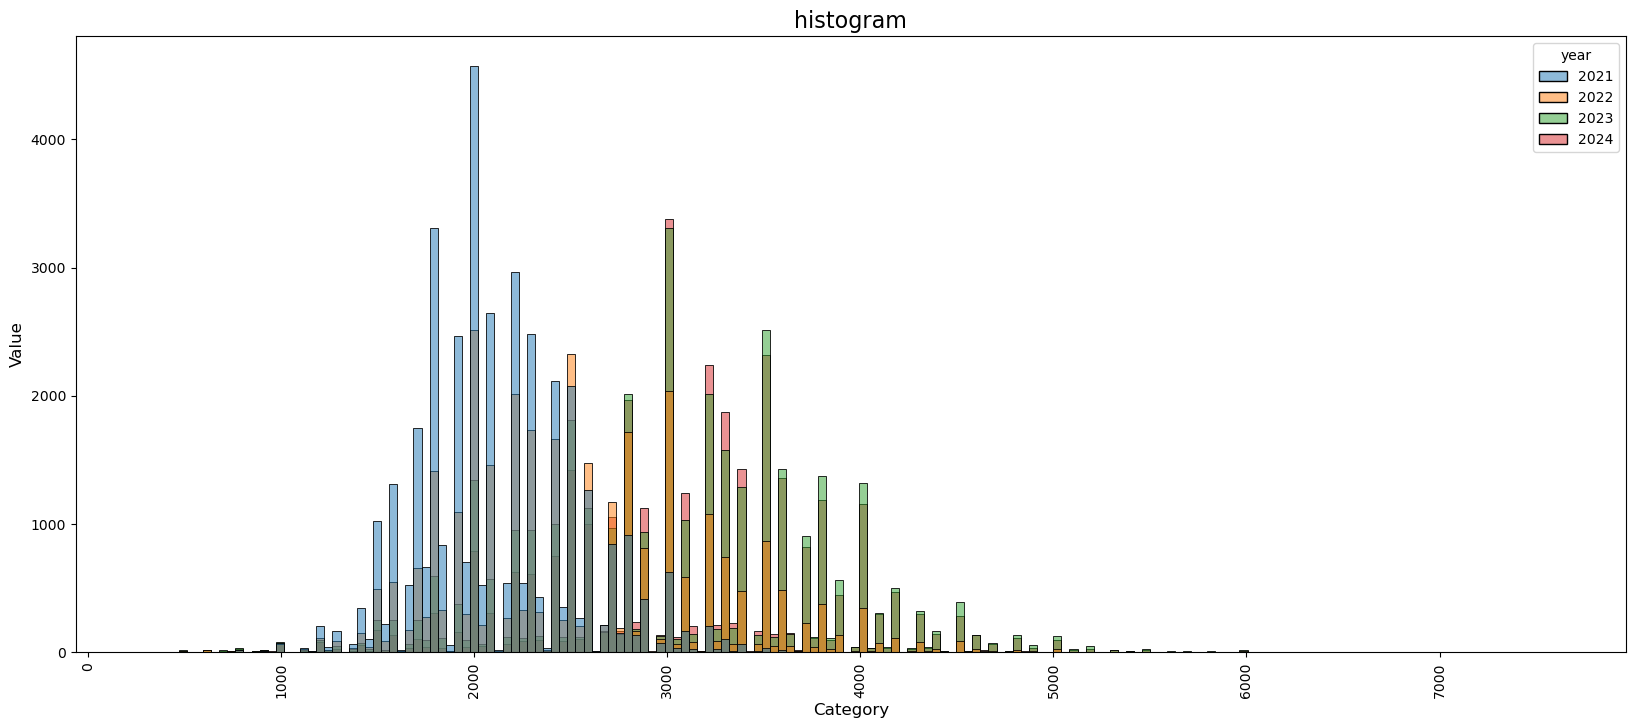

In [15]:
plotting(f'histogram', 'histplot', rental_data_df, 'monthly_rent', 'monthly_rent', category = 'year')

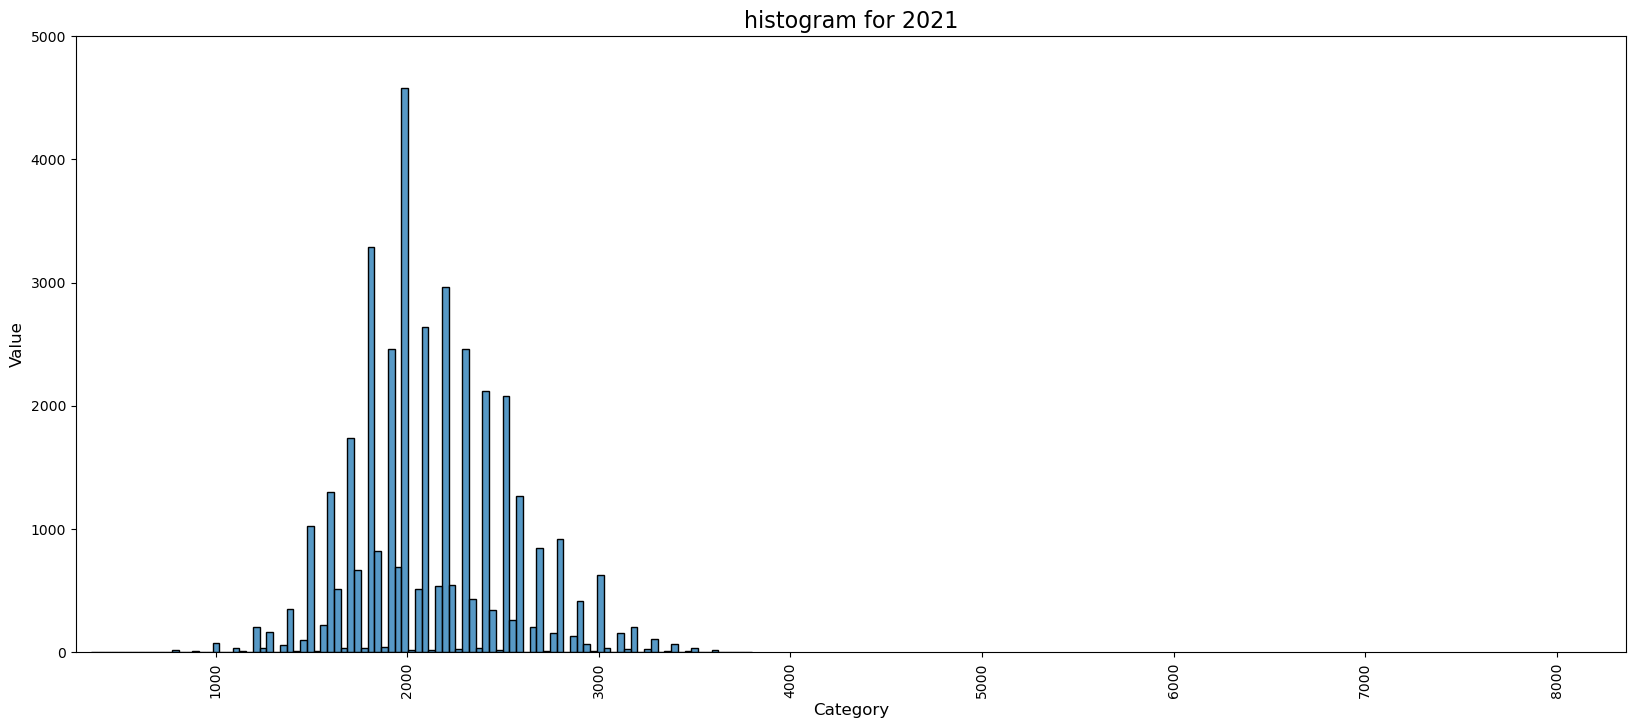

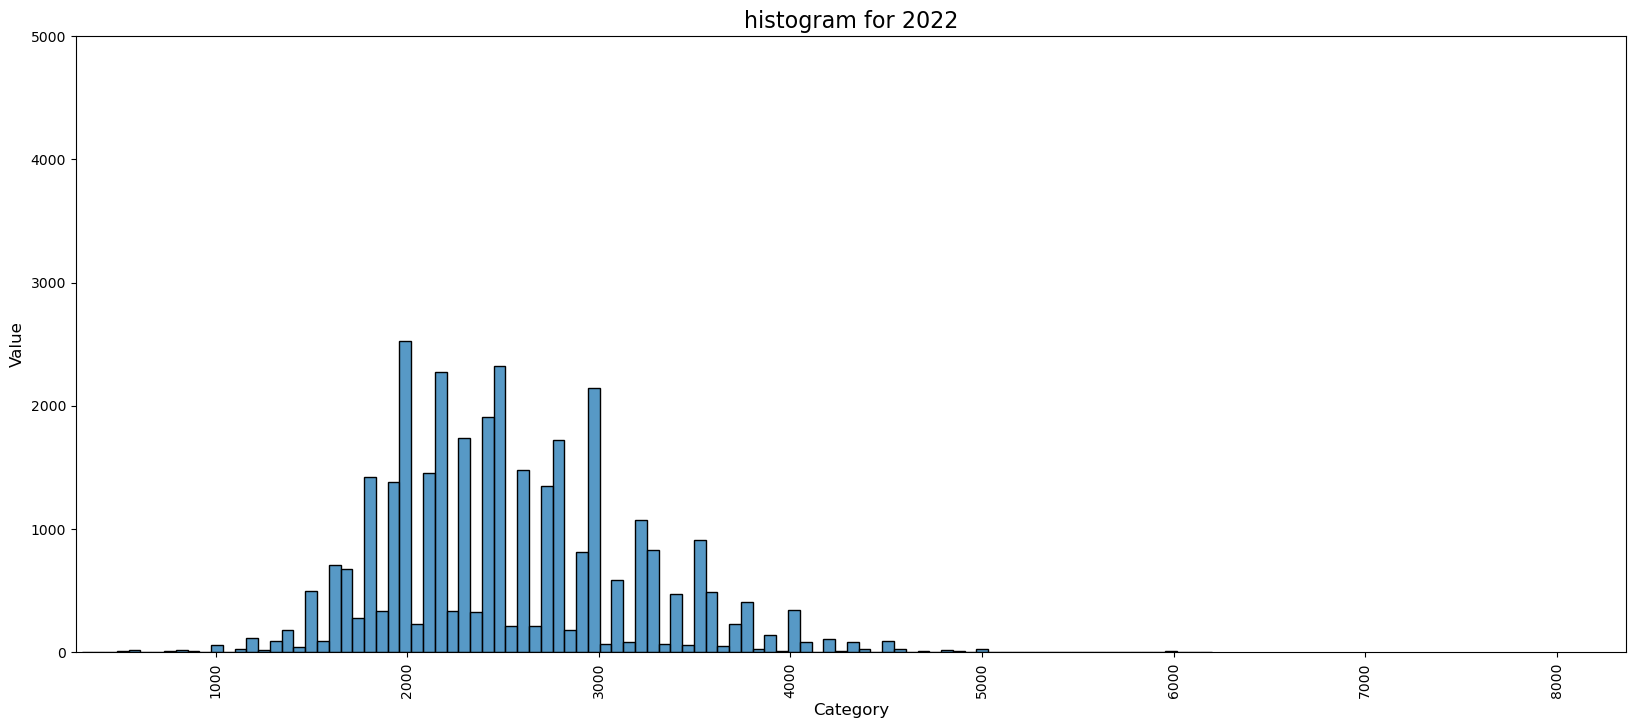

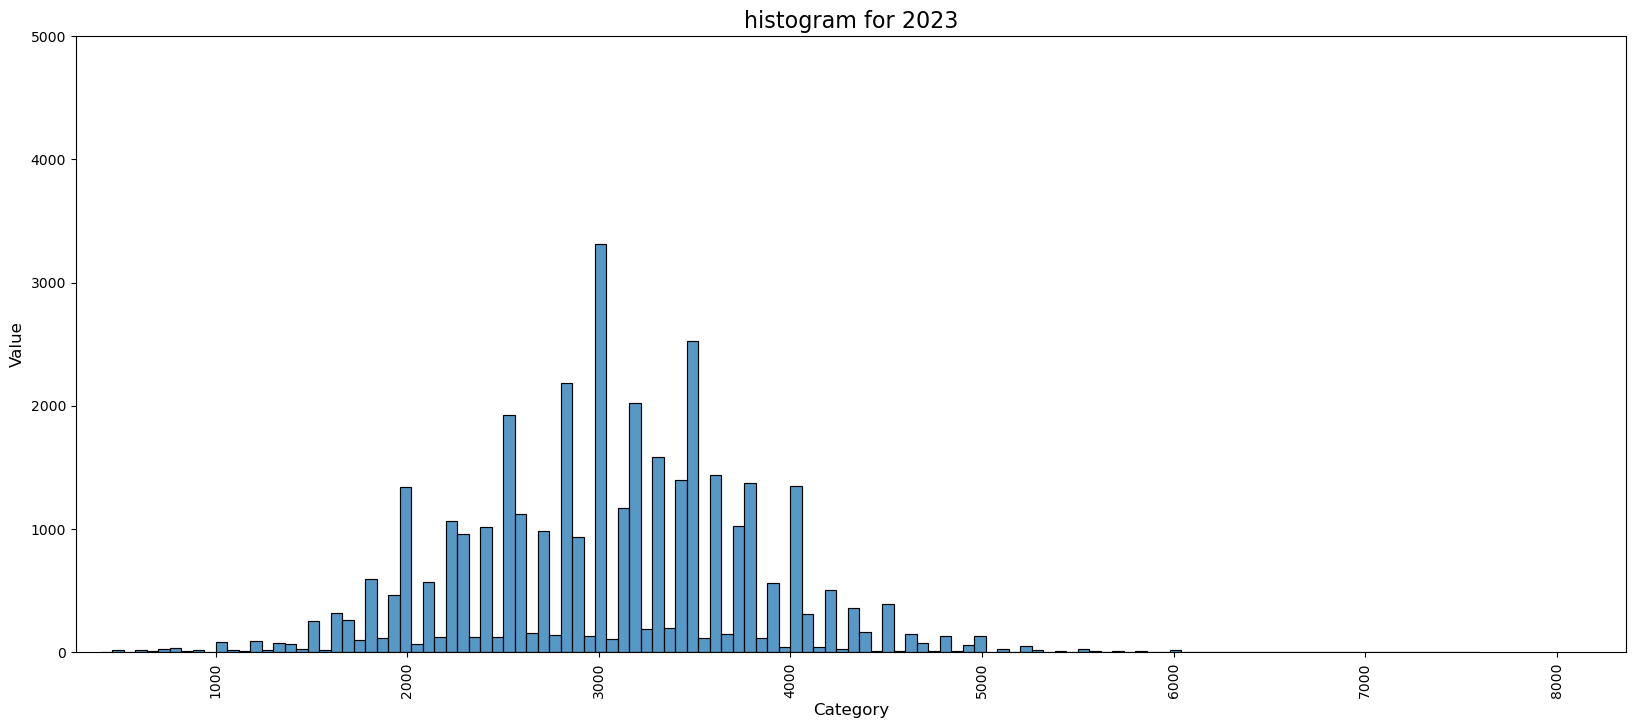

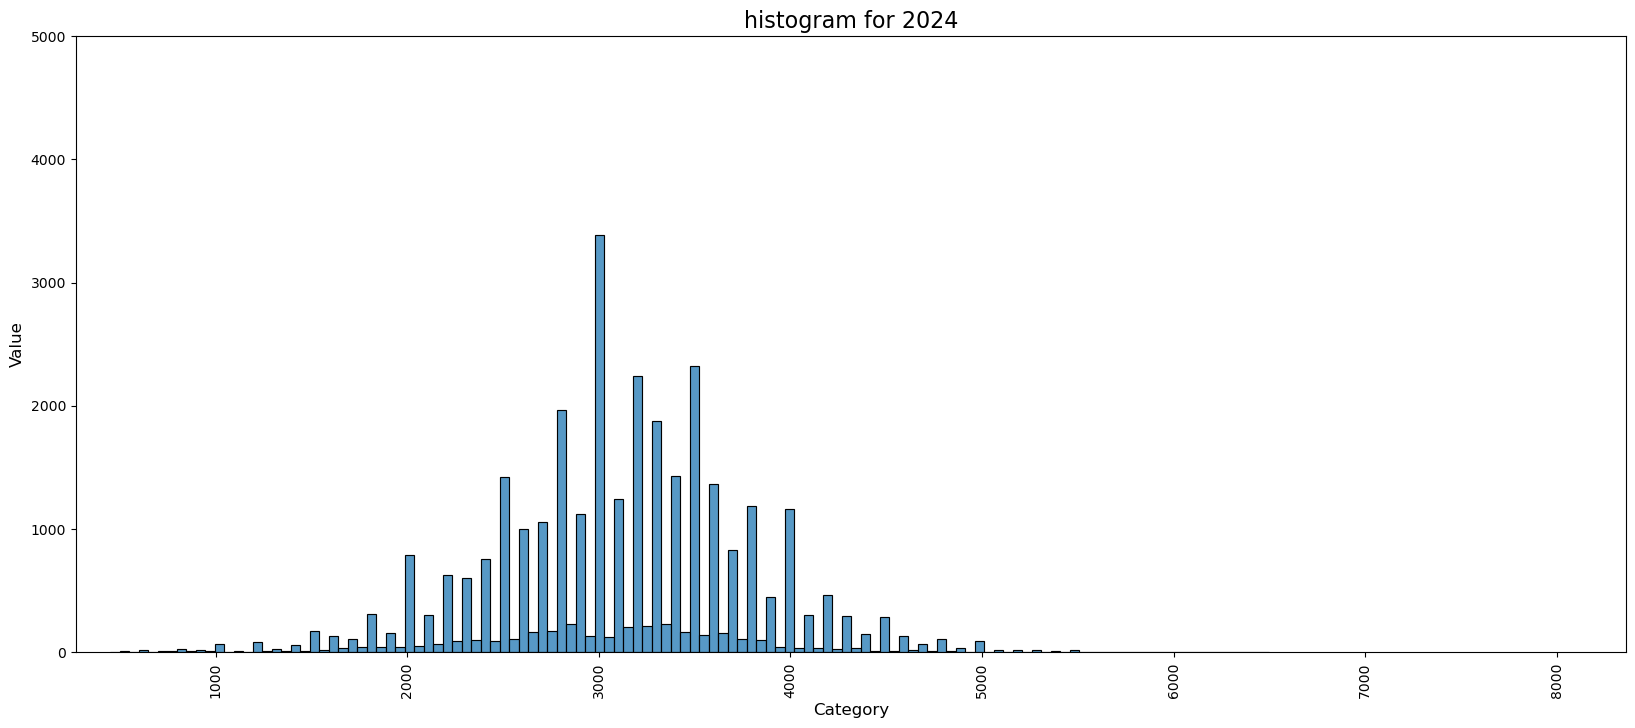

In [16]:
for year in rental_data_df['year'].unique():
    df = rental_data_df[rental_data_df['year'] == year]
    plotting(f'histogram for {year}', 'histplot', df, 'monthly_rent', 'monthly_rent', x_min = rental_data_df['monthly_rent'].min() * 0.9, x_max = rental_data_df['monthly_rent'].max() * 1.1, y_max = 5000)

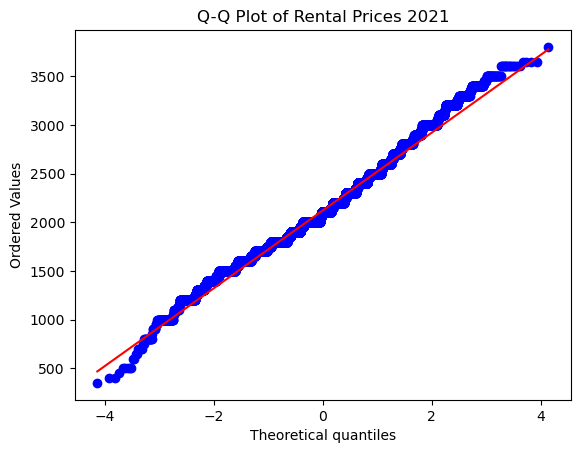

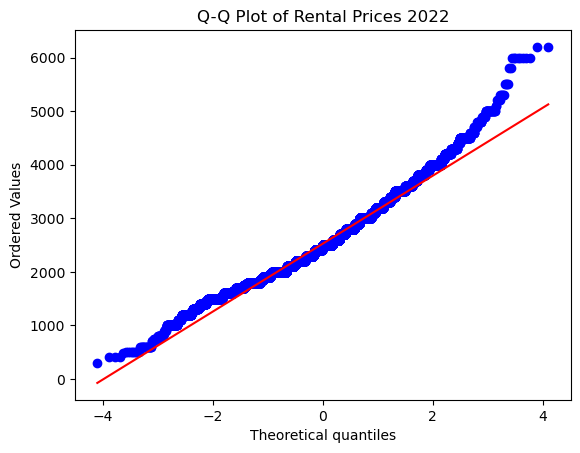

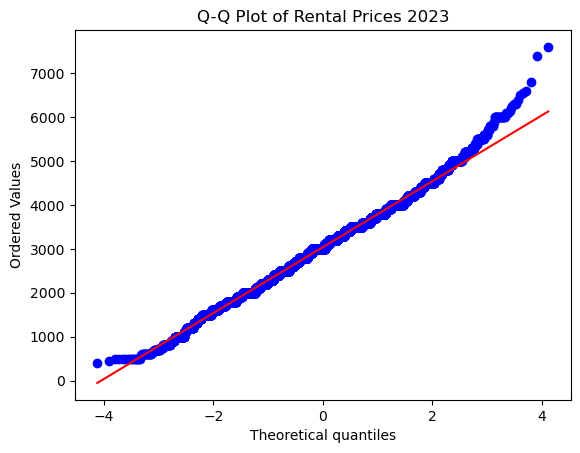

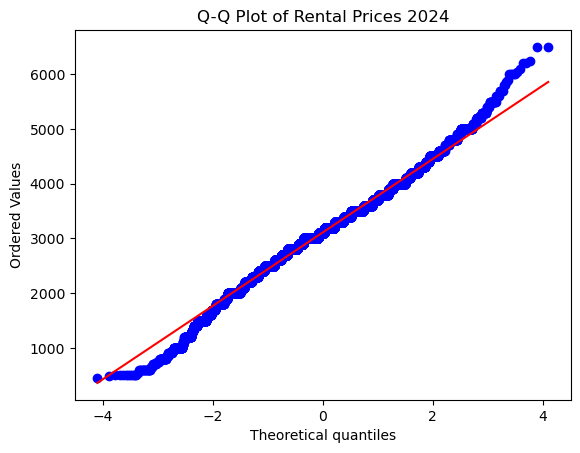

In [17]:
import matplotlib.pyplot as plt

for year in rental_data_df['year'].unique():
    data = rental_data_df[rental_data_df['year'] == year]
    stats.probplot(data['monthly_rent'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Rental Prices {year}")
    plt.show()

In [18]:


for year in rental_data_df['year'].unique():
    data = rental_data_df[rental_data_df['year'] == year]
    result = anderson(data['monthly_rent'])
    print(f"Anderson-Darling Test Statistic: {result.statistic}, Critical Values: {result.critical_values}")
    
    # If the test statistic is greater than the critical value at 5% significance, reject the null hypothesis
    if result.statistic > result.critical_values[2]:
        print("The data is not normally distributed.")
    else:
        print("The data is normally distributed.")


Anderson-Darling Test Statistic: 201.73848831687792, Critical Values: [0.576 0.656 0.787 0.918 1.092]
The data is not normally distributed.
Anderson-Darling Test Statistic: 217.78657963708974, Critical Values: [0.576 0.656 0.787 0.918 1.092]
The data is not normally distributed.
Anderson-Darling Test Statistic: 52.3957344824521, Critical Values: [0.576 0.656 0.787 0.918 1.092]
The data is not normally distributed.
Anderson-Darling Test Statistic: 89.04665368348651, Critical Values: [0.576 0.656 0.787 0.918 1.092]
The data is not normally distributed.


In [19]:
factor = 'year'
years_groups = [group['monthly_rent'].values for name, group in rental_data_df.groupby(factor)]

# Perform Kruskal-Wallis test
h_stat, p_value = kruskal(*years_groups)

# Check the p-value
print(f"Kruskal-Wallis H-statistic: {h_stat}, P-value: {p_value}")

# If p-value < 0.05, reject the null hypothesis (significant difference between groups)
if p_value < 0.05:
    print("There are significant differences in rental prices across the years.")
else:
    print("There are no significant differences in rental prices across the years.")

Kruskal-Wallis H-statistic: 47079.92786508908, P-value: 0.0
There are significant differences in rental prices across the years.


In [20]:
factor = 'town'
years_groups = [group['monthly_rent'].values for name, group in rental_data_df.groupby(factor)]

# Perform Kruskal-Wallis test
h_stat, p_value = kruskal(*years_groups)

# Check the p-value
print(f"Kruskal-Wallis H-statistic: {h_stat}, P-value: {p_value}")

# If p-value < 0.05, reject the null hypothesis (significant difference between groups)
if p_value < 0.05:
    print("There are significant differences in rental prices across the towns.")
else:
    print("There are no significant differences in rental prices across the towns.")

Kruskal-Wallis H-statistic: 4321.879816292842, P-value: 0.0
There are significant differences in rental prices across the towns.


In [21]:
rental_data_df['year'] = pd.to_numeric(rental_data_df['year'], errors='coerce') 
rental_data_df['monthly_rent'] = pd.to_numeric(rental_data_df['monthly_rent'], errors='coerce')  

# Prepare the data (Assuming 'year' is numeric and 'rental_price' is continuous)
X = rental_data_df['year']
y = rental_data_df['monthly_rent']

# Add constant term (intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Get summary of regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           monthly_rent   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                 5.526e+04
Date:                Fri, 27 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:38:36   Log-Likelihood:            -1.1245e+06
No. Observations:              142826   AIC:                         2.249e+06
Df Residuals:                  142824   BIC:                         2.249e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.093e+05   3028.686   -234.188      0.0

# HDB to coordinates

In [22]:
api_key = load_api_key()

In [23]:
# https://www.onemap.gov.sg/apidocs/search

start = time.time()
rental_data_df['postal_code'] = None
rental_data_df['latitude'] = None
rental_data_df['longitude'] = None
row = 0

for address in rental_data_df['address'].unique():
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={address}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    headers = {"Authorization": api_key}
    response = requests.get(url, headers=headers)
    while response.status_code != 200:
        time.sleep(169)
        response = requests.request("GET", url, headers=headers)

    parsed_data = json.loads(response.text)
    rental_data_df.loc[rental_data_df['address'] == address, 'postal_code'] = parsed_data['results'][0]['POSTAL']
    rental_data_df.loc[rental_data_df['address'] == address, 'latitude'] = parsed_data['results'][0]['LATITUDE']
    rental_data_df.loc[rental_data_df['address'] == address, 'longitude'] = parsed_data['results'][0]['LONGITUDE']
    if row%100 == 0:
        print(row, time.time() - start)
    row = row + 1
start -  time.time()

0 0.5612859725952148



KeyboardInterrupt



# Handling wrong postal code

In [32]:
rental_data_df = pd.read_csv('inputs/rental_with_coordinates.csv')

In [33]:
unique_address_postal_df = rental_data_df[['address', 'postal_code']].drop_duplicates(keep ='first')
unique_address_postal_df['postal_code'].value_counts()

postal_code
530211    2
560105    1
680235    1
680410    1
680412    1
         ..
640214    1
640257    1
640258    1
640259    1
670272    1
Name: count, Length: 9541, dtype: int64

In [34]:
rental_data_df.loc[rental_data_df['postal_code'] == '530211']

,rent_approval_date,town,block,street_name,flat_type,monthly_rent,address,DATE,YEAR,MONTH,YEAR_MONTH,postal_code,latitude,longitude
7468,2021-03,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2050,21 HOUGANG AVE 3,2021-03-01,2021,3,2021_3,530211,1.359257,103.887676
17811,2021-06,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1850,21 HOUGANG AVE 3,2021-06-01,2021,6,2021_6,530211,1.359257,103.887676
21134,2021-07,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1500,21 HOUGANG AVE 3,2021-07-01,2021,7,2021_7,530211,1.359257,103.887676
24409,2021-08,HOUGANG,211,HOUGANG ST 21,3-ROOM,2100,211 HOUGANG ST 21,2021-08-01,2021,8,2021_8,530211,1.359257,103.887676
33725,2021-11,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2400,21 HOUGANG AVE 3,2021-11-01,2021,11,2021_11,530211,1.359257,103.887676
36811,2021-12,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2000,21 HOUGANG AVE 3,2021-12-01,2021,12,2021_12,530211,1.359257,103.887676
40156,2022-01,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1750,21 HOUGANG AVE 3,2022-01-01,2022,1,2022_1,530211,1.359257,103.887676
40182,2022-01,HOUGANG,211,HOUGANG ST 21,3-ROOM,2600,211 HOUGANG ST 21,2022-01-01,2022,1,2022_1,530211,1.359257,103.887676
57896,2022-07,HOUGANG,211,HOUGANG ST 21,3-ROOM,2550,211 HOUGANG ST 21,2022-07-01,2022,7,2022_7,530211,1.359257,103.887676
62986,2022-09,HOUGANG,211,HOUGANG ST 21,3-ROOM,2800,211 HOUGANG ST 21,2022-09-01,2022,9,2022_9,530211,1.359257,103.887676


In [25]:
address = '21 HOUGANG AVE 3'
url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={address}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
headers = {"Authorization": api_key}
response = requests.get(url, headers=headers)
while response.status_code != 200:
    time.sleep(169)
    response = requests.request("GET", url, headers=headers)

parsed_data = json.loads(response.text)
rental_data_df.loc[rental_data_df['address'] == address, 'postal_code'] = parsed_data['results'][0]['POSTAL']
rental_data_df.loc[rental_data_df['address'] == address, 'latitude'] = parsed_data['results'][0]['LATITUDE']
rental_data_df.loc[rental_data_df['address'] == address, 'longitude'] = parsed_data['results'][0]['LONGITUDE']

C:\Users\EGGCAKE\AppData\Local\Temp\ipykernel_6184\3342595540.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.35925696781362' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  rental_data_df.loc[rental_data_df['address'] == address, 'latitude'] = parsed_data['results'][0]['LATITUDE']
C:\Users\EGGCAKE\AppData\Local\Temp\ipykernel_6184\3342595540.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '103.887676276425' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  rental_data_df.loc[rental_data_df['address'] == address, 'longitude'] = parsed_data['results'][0]['LONGITUDE']


In [27]:
rental_data_df.loc[rental_data_df['address'] == address]

,rent_approval_date,town,block,street_name,flat_type,monthly_rent,address,DATE,YEAR,MONTH,YEAR_MONTH,postal_code,latitude,longitude
7468,2021-03,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2050,21 HOUGANG AVE 3,2021-03-01,2021,3,2021_3,530211,1.35925696781362,103.887676276425
17811,2021-06,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1850,21 HOUGANG AVE 3,2021-06-01,2021,6,2021_6,530211,1.35925696781362,103.887676276425
21134,2021-07,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1500,21 HOUGANG AVE 3,2021-07-01,2021,7,2021_7,530211,1.35925696781362,103.887676276425
33725,2021-11,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2400,21 HOUGANG AVE 3,2021-11-01,2021,11,2021_11,530211,1.35925696781362,103.887676276425
36811,2021-12,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2000,21 HOUGANG AVE 3,2021-12-01,2021,12,2021_12,530211,1.35925696781362,103.887676276425
40156,2022-01,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1750,21 HOUGANG AVE 3,2022-01-01,2022,1,2022_1,530211,1.35925696781362,103.887676276425
65485,2022-10,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1900,21 HOUGANG AVE 3,2022-10-01,2022,10,2022_10,530211,1.35925696781362,103.887676276425
70775,2022-12,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2900,21 HOUGANG AVE 3,2022-12-01,2022,12,2022_12,530211,1.35925696781362,103.887676276425
70776,2022-12,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2000,21 HOUGANG AVE 3,2022-12-01,2022,12,2022_12,530211,1.35925696781362,103.887676276425
76337,2023-02,HOUGANG,21,HOUGANG AVE 3,3-ROOM,3600,21 HOUGANG AVE 3,2023-02-01,2023,2,2023_2,530211,1.35925696781362,103.887676276425


In [35]:
rental_data_df.loc[rental_data_df['address'] == address, 'postal_code'] = '530021'
rental_data_df.loc[rental_data_df['address'] == address, 'latitude'] = 1.36424
rental_data_df.loc[rental_data_df['address'] == address, 'longitude'] = 103.8914777

In [36]:
rental_data_df.loc[rental_data_df['address'] == address]

,rent_approval_date,town,block,street_name,flat_type,monthly_rent,address,DATE,YEAR,MONTH,YEAR_MONTH,postal_code,latitude,longitude
7468,2021-03,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2050,21 HOUGANG AVE 3,2021-03-01,2021,3,2021_3,530021,1.36424,103.891478
17811,2021-06,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1850,21 HOUGANG AVE 3,2021-06-01,2021,6,2021_6,530021,1.36424,103.891478
21134,2021-07,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1500,21 HOUGANG AVE 3,2021-07-01,2021,7,2021_7,530021,1.36424,103.891478
33725,2021-11,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2400,21 HOUGANG AVE 3,2021-11-01,2021,11,2021_11,530021,1.36424,103.891478
36811,2021-12,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2000,21 HOUGANG AVE 3,2021-12-01,2021,12,2021_12,530021,1.36424,103.891478
40156,2022-01,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1750,21 HOUGANG AVE 3,2022-01-01,2022,1,2022_1,530021,1.36424,103.891478
65485,2022-10,HOUGANG,21,HOUGANG AVE 3,3-ROOM,1900,21 HOUGANG AVE 3,2022-10-01,2022,10,2022_10,530021,1.36424,103.891478
70775,2022-12,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2900,21 HOUGANG AVE 3,2022-12-01,2022,12,2022_12,530021,1.36424,103.891478
70776,2022-12,HOUGANG,21,HOUGANG AVE 3,3-ROOM,2000,21 HOUGANG AVE 3,2022-12-01,2022,12,2022_12,530021,1.36424,103.891478
76337,2023-02,HOUGANG,21,HOUGANG AVE 3,3-ROOM,3600,21 HOUGANG AVE 3,2023-02-01,2023,2,2023_2,530021,1.36424,103.891478


In [38]:
rental_data_df

,rent_approval_date,town,block,street_name,flat_type,monthly_rent,address,DATE,YEAR,MONTH,YEAR_MONTH,postal_code,latitude,longitude
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000,105 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560105,1.372313,103.837601
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750,107 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560107,1.371384,103.837381
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750,108 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560108,1.370966,103.838202
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230,111 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560111,1.370851,103.837298
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450,111 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560111,1.370851,103.837298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142821,2024-11,CLEMENTI,708,CLEMENTI WEST ST 2,4-ROOM,3800,708 CLEMENTI WEST ST 2,2024-11-01,2024,11,2024_11,120708,1.305719,103.762168
142822,2024-11,YISHUN,225,YISHUN ST 21,4-ROOM,3000,225 YISHUN ST 21,2024-11-01,2024,11,2024_11,760225,1.434831,103.835814
142823,2024-11,PUNGGOL,134,EDGEDALE PLAINS,5-ROOM,3200,134 EDGEDALE PLAINS,2024-11-01,2024,11,2024_11,820134,1.392335,103.910181
142824,2024-11,JURONG EAST,44,TEBAN GDNS RD,4-ROOM,3500,44 TEBAN GDNS RD,2024-11-01,2024,11,2024_11,600044,1.320754,103.741600


In [39]:
rental_data_df.to_csv('inputs/rental_with_coordinates.csv', index = False)